In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import math
import numpy as np
import hashlib
import json 

In [3]:
class CountMinSketch:
    def __init__(self, eps, delta):
        self.eps = eps
        self.delta = delta
        self.w = math.ceil(np.exp(1) / eps)
        self.d = math.ceil(np.log(1 / delta))
        self.tables = np.zeros((self.d, self.w))
        self.backup = {}

    def compute_hash(self, value, table_no):
        fn = hashlib.md5()
        inp = str(value) + str(0) + str(table_no)
        fn.update(inp.encode())
        out = int(fn.hexdigest(), 16)
        return out % self.w

    def count(self, value):
        if str(value) in self.backup: 
            self.backup[str(value)] = self.backup[str(value)] + 1
        else:
            self.backup[str(value)] = 1
        for i in range(self.d):
            j = self.compute_hash(value, i)
            self.tables[i][j] = self.tables[i][j] + 1

    def estimate(self, value):
        ests = []
        for i in range(self.d):
            j = self.compute_hash(value, i)
            ests.append(self.tables[i][j])
        return min(ests)

    def real_estimate(self, value):
        if str(value) in self.backup: return self.backup[str(value)]
        return -1

    def compute_size(self):
        size = 0
        for key in self.backup:
            size += abs(self.backup[key])
        return size

    def save_counts(self, count_filename='counts.txt', actual_filename='backups.txt'):
        np.savetxt(count_filename, self.tables)
        with open(actual_filename, 'w') as fp: json.dump(self.backup, fp)

    def load_counts(self, count_filename='counts.txt', actual_filename='backups.txt'):
        with open(actual_filename, 'r') as fp: 
            temp = json.load(fp)
            self.backup = temp
        self.tables = np.loadtxt(count_filename)

In [4]:
import scipy.stats as stats

In [5]:
def generate_sample(n=1000, dist='uniform', loc=0, scale=1000, lambda_=5, s=1):
  if dist == 'uniform':
    float_sample = stats.uniform.rvs(loc, scale, n)
    return [int(el) for el in float_sample]
  if dist == 'zipf':
    float_sample = stats.zipf.rvs(loc + 1, size=n)
    return [int(el) for el in float_sample]
  if dist == 'exp':
    float_sample = stats.planck.rvs(lambda_, size=n)
    return [int(el) for el in float_sample]
  if dist == 'lognorm':
    float_sample = stats.lognorm.rvs(s=scale, size=n)
    return [int(el) for el in float_sample]
  if dist == 'geometric':
    float_sample =  stats.geom.rvs(p, size=n)
    return [int(el) for el in float_sample]
  elif dist == 'normal':
    float_sample = stats.norm.rvs(loc, scale, n)
    return [int(el) for el in float_sample]
  else:
    return -1

In [6]:
cms = CountMinSketch(0.03, 0.5)

In [7]:
uniform_sample = generate_sample()
for el in uniform_sample:
  cms.count(el)

In [8]:
def compute_error_prob(cms, data, n):
  err = []
  for el in data:
    err.append(cms.estimate(el) - cms.real_estimate(el))
  avg_err = sum(err) / len(err)
  max_err = max(err)
  exceed = 0
  for el in err:
    if el > cms.eps * n:
      exceed += 1
  return exceed / len(err), err

In [9]:
def load_data(cms, data):
  for el in data:
    cms.count(el)

In [10]:
def run_experiment():
  n = 1000
  eps = 0.01
  min_delta = 0.01
  max_delta = 0.1
  deltas = np.linspace(min_delta, max_delta, 10).tolist()
  # deltas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  ps = []
  for delta in deltas:
    probs = 0
    for i in range(3):
      cms = CountMinSketch(eps, delta)
      print(cms.w)
      dt = generate_sample(n)
      load_data(cms, dt)
      p, err = compute_error_prob(cms, dt, n)
      print(err)
      probs += p
    probs /= 3
    ps.append(probs)
  return deltas, ps, err



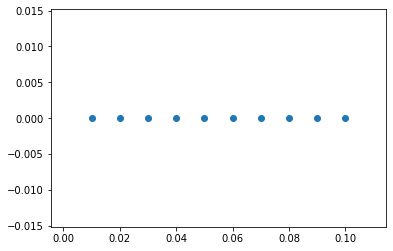

In [11]:
# VISUALIZE ERROR PROBABILITY VS DELTA

# compute empirical probability of error exceeding the threshold
def compute_error_prob(cms, data, n):
  err = []
  for el in data:
    err.append(cms.estimate(el) - cms.real_estimate(el))
  avg_err = sum(err) / len(err)
  max_err = max(err)
  exceed = 0
  for el in err:
    if el > cms.eps * n:
      exceed += 1
  p = exceed / len(err)
  return p, avg_err, max_err, err

# run experiments on 10 values of delta interpolated between (min_delta, max_delta) and compute array of corresponding error probabilities
def error_prob_vs_delta(n=100000, eps=0.4, min_delta=0.01, max_delta=0.1):
  deltas = np.linspace(min_delta, max_delta, 10).tolist()
  # deltas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
  ps = []
  for delta in deltas:
    probs = 0
    # Average probabilities across 3 trials
    for i in range(3):
      cms = CountMinSketch(eps, delta)
      dt = generate_sample(n)
      load_data(cms, dt)
      p, avg_err, max_err, err = compute_error_prob(cms, dt, n)
      probs += p
    probs /= 3
    ps.append(probs)
  return deltas, ps

# graphing helper function
def graph_error_prob_vs_delta(deltas, ps, filename="p_vs_delta.png"):
  plt.scatter(deltas, ps)
  plt.show()

# actual code to run experiment:
deltas, ps = error_prob_vs_delta()
graph_error_prob_vs_delta(deltas, ps)

Average Error: 11.7769
Maximum Error: 77.0
Acceptable Threshold: 100.0
Proportion of Errors Exceeding Threshold: 0.0


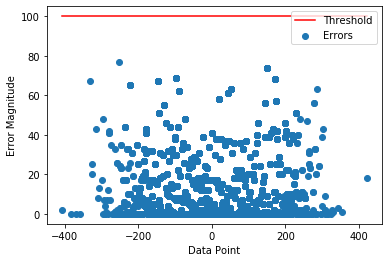

In [12]:
# VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON UNIFORM DATA
eps = 0.01
delta = 0.05
n = 10000
threshold = eps * n
sample = generate_sample(n=n, dist='normal', loc=0, scale=100)

cms = CountMinSketch(eps, delta)
load_data(cms, sample)

p, avg_err, max_err, err = compute_error_prob(cms, sample, n)

print("Average Error: " + str(avg_err))
print("Maximum Error: " + str(max_err))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p))

plt.scatter(sample, err, label = "Errors")
plt.ylabel("Error Magnitude")
plt.xlabel("Data Point")
plt.plot([min(sample), max(sample)], [threshold, threshold], color='red', label = "Threshold")
plt.legend(loc=1)
plt.savefig("normal.png")
plt.show()


Average Error: 11.7451
Maximum Error: 96.0
Acceptable Threshold: 100.0
Proportion of Errors Exceeding Threshold: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


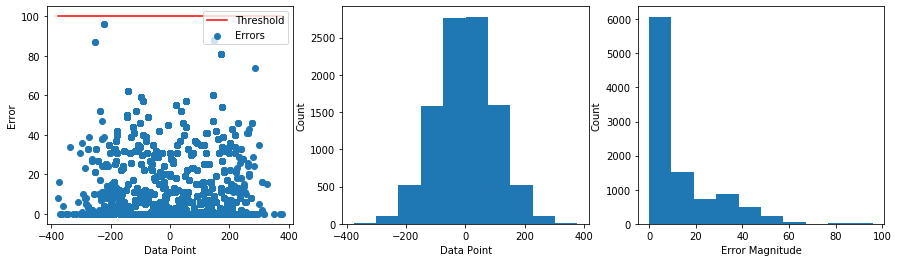

In [13]:
# VISUALIZE HOW ERROR CHANGES BY COMPRESSING THE NORMAL DISTRIBUTION
eps = 0.01
delta = 0.05
n = 10000
threshold = eps * n

mean = 0
sd = 100
sample = generate_sample(n=n, dist='normal', loc=mean, scale=sd)

cms = CountMinSketch(eps, delta)
load_data(cms, sample)

p, avg_err, max_err, err = compute_error_prob(cms, sample, n)

print("Average Error: " + str(avg_err))
print("Maximum Error: " + str(max_err))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p))

fig, (f1, f2, f3) = plt.subplots(1,3)
fig.set_size_inches(15, 4)

f1.scatter(sample, err, label="Errors")
f1.plot([min(sample), max(sample)], [threshold, threshold], color='red', label="Threshold")
f1.legend(loc=1)
f1.set(ylabel="Error", xlabel="Data Point")
f2.hist(sample)
f2.set(ylabel="Count", xlabel="Data Point")
f3.hist(err)
f3.set(ylabel="Count", xlabel="Error Magnitude")
fig.savefig("normal2.png")
fig.show()

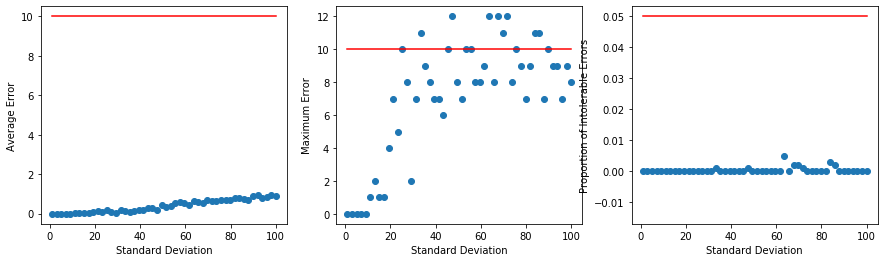

In [14]:
# Plot Average Error vs. SD
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n

mean=0
min_sd=1
max_sd=100

def error_vs_sd(eps=0.01, delta=0.05, n=1000, mean=0, min_sd=50, max_sd=500):
  sds = np.linspace(min_sd, max_sd).tolist()
  avgs = []
  maxs = []
  ps = []

  for sd in sds:
    sample = generate_sample(n=1000, dist='normal', loc=mean, scale=sd)
    cms = CountMinSketch(eps, delta)
    load_data(cms, sample)
    p, avg_err, max_err, err = compute_error_prob(cms, sample, n)
    avgs.append(avg_err)
    maxs.append(max_err)
    ps.append(p)
  
  threshold = eps * n
  return sds, avgs, maxs, ps, threshold

# actual code
sds, avgs, maxs, ps, threshold = error_vs_sd(eps, delta, n, mean, min_sd, max_sd)
fig, (f1, f2, f3) = plt.subplots(1, 3)
fig.set_size_inches(15, 4)
f1.scatter(sds, avgs)
f1.plot([min(sds), max(sds)], [threshold, threshold], color='red')
f1.set(xlabel="Standard Deviation", ylabel="Average Error")
f2.scatter(sds, maxs)
f2.plot([min(sds), max(sds)], [threshold, threshold], color='red')
f2.set(ylabel="Maximum Error", xlabel="Standard Deviation")
f3.scatter(sds, ps)
f3.plot([min(sds), max(sds)], [delta, delta], color='red')
f3.set(ylabel="Proportion of Intolerable Errors", xlabel="Standard Deviation")
plt.savefig("3panel.png")
plt.show()


In [15]:
from sklearn import svm
from collections import Counter
from sklearn.neural_network import MLPClassifier

In [16]:
class LearnedCountMinSketch:
    def __init__(self, eps, delta, train_data):
        self.eps = eps
        self.delta = delta
        self.cms = CountMinSketch(eps, delta)

        # set model
        X_train = train_data[0]
        Y_train = train_data[1]
        self.model = MLPClassifier(hidden_layer_sizes=(30, 40))
        self.model.fit(X_train.reshape(-1, 1), np.ravel(Y_train))
        self.perfect = {}

    def count(self, value):
        if (self.model.predict(np.array([value]).reshape(-1, 1)) == 1):
            if str(value) in self.perfect:
                self.perfect[str(value)] = self.perfect[str(value)] + 1
            else:
                self.perfect[str(value)] = 1
        else:
            self.cms.count(value)

    def estimate(self, value):
        if (self.model.predict(np.array([value]).reshape(-1, 1)) == 1):
            if str(value) in self.perfect: return self.perfect[str(value)]
            return 0
        else:
            return self.cms.estimate(value)

    def real_estimate(self, value):
        if str(value) in self.perfect: return self.perfect[str(value)]
        if str(value) in self.cms.backup: return self.cms.backup[str(value)]
        return -1

    def compute_size(self):
        size = 0
        for key in self.cms.backup:
            size += abs(self.cms.backup[key])
        for key in self.perfect:
            size += abs(self.perfect[key])
        return size

In [17]:
# label data --> threshold is what proportion of data points you want to call "heavy hitters"
def label_sample(sample, p = 0.05):
    n = len(sample)
    n_distinct = len(Counter(sample).keys())
    num = int(n_distinct * p)
    X_train = np.array(sample)
    Y_train = np.zeros_like(X_train)
    hh = Counter(sample).most_common(num)
    hh = set([el[0] for el in hh])
    for i in range(n):
        if X_train[i] in hh:
            Y_train[i] = 1
    return X_train, Y_train, hh

Regular Count Min Sketch:
Average Error: 1.515
Maximum Error: 9.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.0

Learned Count Min Sketch:
Average Error: 0.044
Maximum Error: 3.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


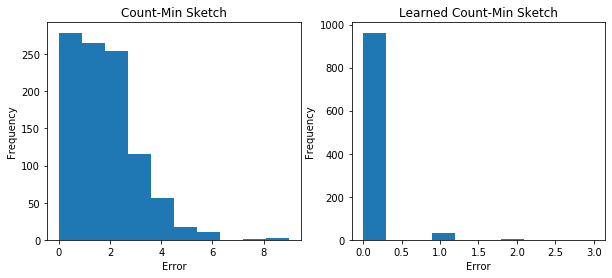

In [23]:
# VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON UNIFORM DATA
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n
sample = generate_sample(n=n)
X_tr, Y_tr, hh = label_sample(sample, p = 0.3)

lcms = LearnedCountMinSketch(eps, delta, [X_tr, Y_tr])
cms = CountMinSketch(eps, delta)

load_data(lcms, sample)
load_data(cms, sample)

p1, avg_err1, max_err1, err1 = compute_error_prob(cms, sample, n)
p2, avg_err2, max_err2, err2 = compute_error_prob(lcms, sample, n)

print("Regular Count Min Sketch:")
print("Average Error: " + str(avg_err1))
print("Maximum Error: " + str(max_err1))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p1))
print("\nLearned Count Min Sketch:")
print("Average Error: " + str(avg_err2))
print("Maximum Error: " + str(max_err2))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p2))

fig, (f1, f2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
f1.hist(err1)
# f1.scatter(sample, err1)
f1.set(title="Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f1.plot([min(sample), max(sample)], [threshold, threshold], color='red')
# f2.scatter(sample, err2)
f2.hist(err2)
f2.set(title="Learned Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f2.plot([min(sample), max(sample)], [threshold, threshold], color='red')
fig.savefig("uniform_comparison.png")
fig.show()

Regular Count Min Sketch:
Average Error: 0.987
Maximum Error: 11.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.001

Learned Count Min Sketch:
Average Error: 0.236
Maximum Error: 6.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


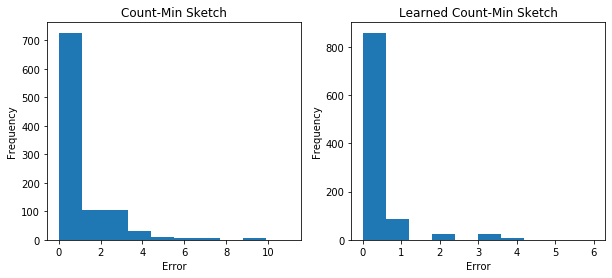

In [19]:
# VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON NORMAL DATA
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n

p = 0.2

mean = 0
sd = 100

sample = generate_sample(n=n, dist='normal', loc=mean, scale=sd)
X_tr, Y_tr, hh = label_sample(sample, p)

lcms = LearnedCountMinSketch(eps, delta, [X_tr, Y_tr])
cms = CountMinSketch(eps, delta)

load_data(lcms, sample)
load_data(cms, sample)

p1, avg_err1, max_err1, err1 = compute_error_prob(cms, sample, n)
p2, avg_err2, max_err2, err2 = compute_error_prob(lcms, sample, n)

print("Regular Count Min Sketch:")
print("Average Error: " + str(avg_err1))
print("Maximum Error: " + str(max_err1))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p1))
print("\nLearned Count Min Sketch:")
print("Average Error: " + str(avg_err2))
print("Maximum Error: " + str(max_err2))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p2))

fig, (f1, f2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
f1.hist(err1)
f1.set(title="Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f1.scatter(sample, err1)
# f1.plot([min(sample), max(sample)], [threshold, threshold], color='red')
# f2.scatter(sample, err2)
f2.hist(err2)
f2.set(title="Learned Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f2.plot([min(sample), max(sample)], [threshold, threshold], color='red')
fig.savefig("normal_comparison.png")
fig.show()

In [20]:
class RuleCountMinSketch:
    def __init__(self, eps, delta, hh):
        self.eps = eps
        self.delta = delta
        self.cms = CountMinSketch(eps, delta)
        self.hh = hh
        self.perfect = {}

    def count(self, value):
        if value in self.hh:
            if str(value) in self.perfect:
                self.perfect[str(value)] = self.perfect[str(value)] + 1
            else:
                self.perfect[str(value)] = 1
        else:
            self.cms.count(value)

    def estimate(self, value):
        if (value in self.hh):
            if str(value) in self.perfect: return self.perfect[str(value)]
            return 0
        else:
            return self.cms.estimate(value)

    def real_estimate(self, value):
        if str(value) in self.perfect: return self.perfect[str(value)]
        if str(value) in self.cms.backup: return self.cms.backup[str(value)]
        return -1

    def compute_size(self):
        size = 0
        for key in self.cms.backup:
            size += abs(self.cms.backup[key])
        for key in self.perfect:
            size += abs(self.perfect[key])
        return size

Regular Count Min Sketch:
Average Error: 0.985
Maximum Error: 10.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.0

Learned Count Min Sketch:
Average Error: 0.312
Maximum Error: 6.0
Acceptable Threshold: 10.0
Proportion of Errors Exceeding Threshold: 0.0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


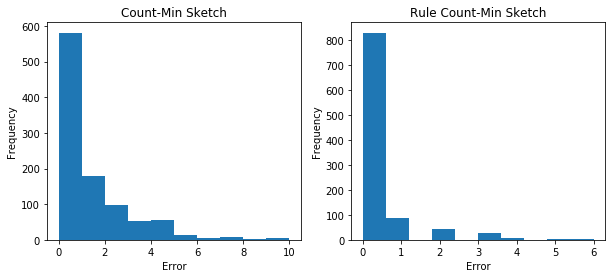

In [21]:
# VISUALIZE HOW ERROR DISTRIBUTION CHANGES WITH EPS, DELTA, N ON NORMAL DATA
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n

p = 0.2

mean = 0
sd = 100

sample = generate_sample(n=n, dist='normal', loc=mean, scale=sd)
X_tr, Y_tr, hh = label_sample(sample, p)

rcms = RuleCountMinSketch(eps, delta, hh)
cms = CountMinSketch(eps, delta)

load_data(rcms, sample)
load_data(cms, sample)

p1, avg_err1, max_err1, err1 = compute_error_prob(cms, sample, n)
p2, avg_err2, max_err2, err2 = compute_error_prob(rcms, sample, n)

print("Regular Count Min Sketch:")
print("Average Error: " + str(avg_err1))
print("Maximum Error: " + str(max_err1))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p1))
print("\nLearned Count Min Sketch:")
print("Average Error: " + str(avg_err2))
print("Maximum Error: " + str(max_err2))
print("Acceptable Threshold: " + str(threshold))
print("Proportion of Errors Exceeding Threshold: " + str(p2))

fig, (f1, f2) = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
f1.hist(err1)
f1.set(title="Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f1.scatter(sample, err1)
# f1.plot([min(sample), max(sample)], [threshold, threshold], color='red')
# f2.scatter(sample, err2)
f2.hist(err2)
f2.set(title="Rule Count-Min Sketch", xlabel="Error", ylabel="Frequency")
# f2.plot([min(sample), max(sample)], [threshold, threshold], color='red')
fig.savefig("rule_comparison.png")
fig.show()

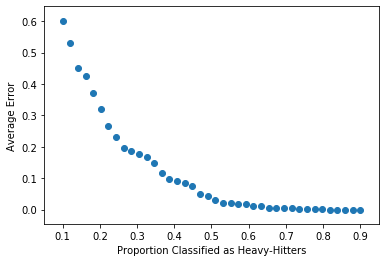

In [22]:
eps = 0.01
delta = 0.05
n = 1000
threshold = eps * n

min_p = 0
max_p = 1

mean = 0
sd = 100

def compute_avg_errors_vs_ps(n=1000, mean=0, sd=100, min_p = 0.1, max_p = 0.9, num_p = 40):
  sample = generate_sample(n,dist='normal', loc=mean, scale=sd)
  ps = np.linspace(min_p, max_p, num_p).tolist()
  avgs = []
  for p in ps:
    X_tr, Y_tr, hh = label_sample(sample, p)
    rcms = RuleCountMinSketch(eps, delta, hh)
    load_data(rcms, sample)
    _, avg_err, _, _ = compute_error_prob(rcms, sample, n)
    avgs.append(avg_err)
  return ps, avgs

ps, avgs = compute_avg_errors_vs_ps()
plt.scatter(ps, avgs)
plt.xlabel("Proportion Classified as Heavy-Hitters")
plt.ylabel("Average Error")
plt.savefig("pgraph.png")
plt.show()